# Reading and evaluating PTB correlation data


In [1]:
from scipy import rand

# temp import only
from empir19nrm02.tools.help import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity

#%run -i jhelp


import luxpy as lx
import numpy as np
from matplotlib import pyplot
from sklearn.linear_model import LinearRegression

from empir19nrm02.f1prime import py_f1PrimeGlx
from empir19nrm02.tools import plotCorrMatrixSmall
%matplotlib inline
from empir19nrm02.tools.help import plotCorrelation
from empir19nrm02.tools import plotHistScales
from empir19nrm02.MC import DistributionParam, MCVar, MCSimulation, NameUnit, MCVectorVar, pickle_copy, save_to_csv, save_to_excel, load_from_csv, load_from_excel

import luxpy as lx
from luxpy import _CIE_ILLUMINANTS, _CMF

out_dir = 'MCSim_Test'

import os
print( 'CWD:', os.getcwd())

CWD: E:\TTBV\Python\empir19nrm02\empir19nrm02\Jupyter


In [2]:
def get_data_dir( name):
    # handle the naming conventions of the data
    if 'Rad' in rad:
        directory = 'E:/TTBV/Python/PTB/Radiometers/' + rad + '/' + rad + ' MC-results'
        out_dir_res = out_dir + '/Radiometer/' + rad
    if 'Phot' in rad:
        directory = 'E:/TTBV/Python/PTB/Photometers/' + rad + '/' + rad + ' MC-results'
        out_dir_res = out_dir + '/Photometer/' + rad
    if 'FEL' in rad:
        directory = 'E:/TTBV/Python/PTB/Lamps/' + rad + '/MC-Data-' + rad
        out_dir_res = out_dir + '/Lamps/' + rad
    return directory, out_dir_res


In [3]:
def plotMCResult( wl, mcVar, title=None, fig = None, ax1 = None, ax2 = None, diagnumber=0):
    bFirst = False
    if not fig:
        fig, ax1 = pyplot.subplots()
        ax2 = ax1.twinx()
        color1 = 'r-'
        color2 = 'g-'
    else:
        if diagnumber == 1:
            color1 = 'r--'
            color2 = 'g--'
        else:
            color1 = 'r-.'
            color2 = 'g-.'

    if not title:
        title = ''
    ax1.plot(wl, mcVar.v_mean/np.max(mcVar.v_mean), color1, label= title + ' $s_{\mathrm{rel}}(\lambda)$')
    ax2.plot(wl, mcVar.v_std / mcVar.v_mean, color2, label= title + ' $u_{\mathrm{rel}}(s_{\mathrm{rel}})(\lambda)$')
    ax1.set_xlabel(strd['xlambda'])
    ax1.set_ylabel('Signal / A.U', color = 'red')
    ax2.set_ylabel('$\sigma_{\mathrm{rel}}$', color = 'green')
    if title:
        ax1.set_title(title)
    fig.legend()
    return fig, ax1, ax2

Processing: FEL-1000W-Lamp-1  from dir: E:/TTBV/Python/PTB/Lamps/FEL-1000W-Lamp-1/MC-Data-FEL-1000W-Lamp-1
Store results into: MCSim_Test/Lamps/FEL-1000W-Lamp-1
Number of Runs: 6572
Shape of the covariance matrix: (124, 124)
Shape of the corr matrix (generated from the cov matrix): (124, 124)


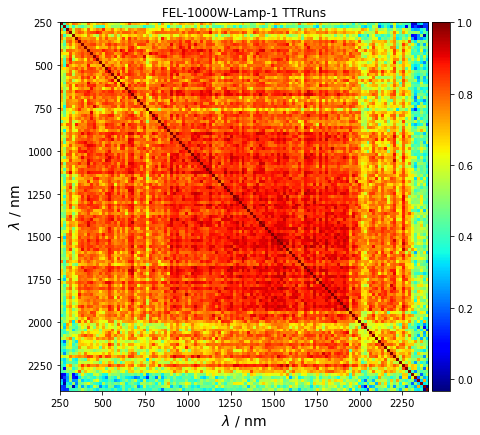

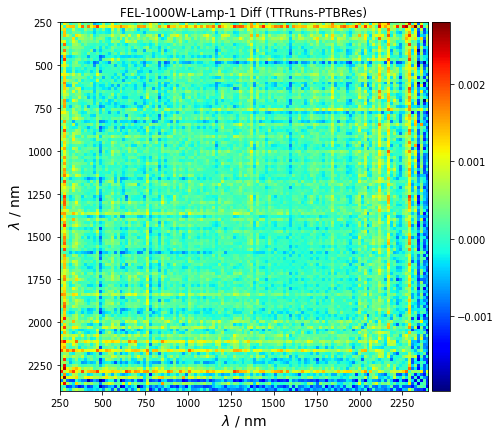

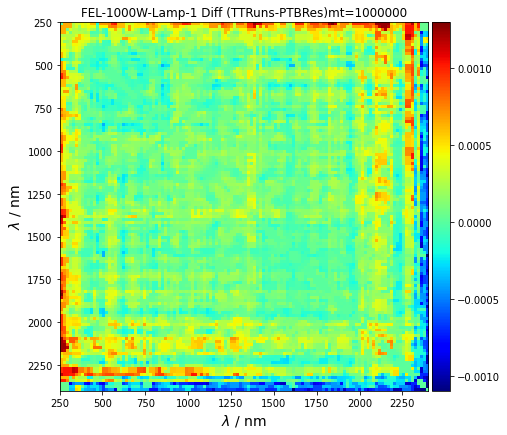

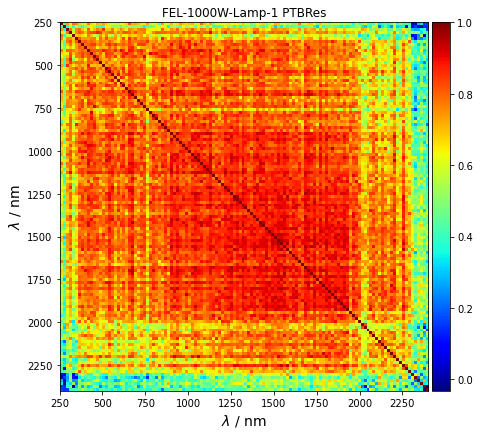

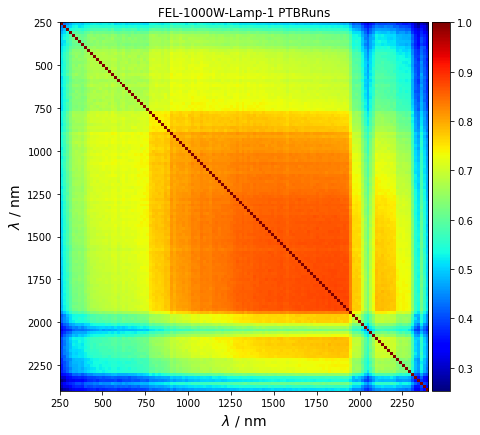

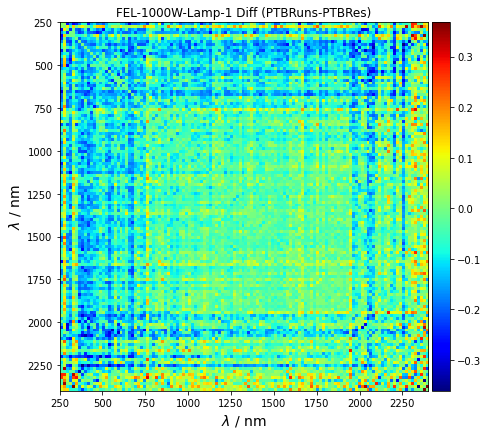

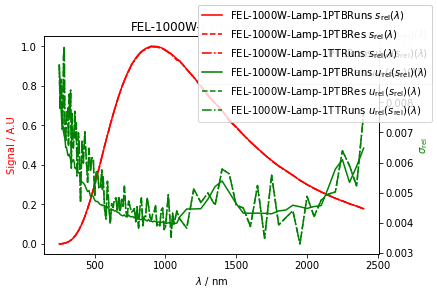

Processing: FEL-1000W-Lamp-2  from dir: E:/TTBV/Python/PTB/Lamps/FEL-1000W-Lamp-2/MC-Data-FEL-1000W-Lamp-2
Store results into: MCSim_Test/Lamps/FEL-1000W-Lamp-2
Number of Runs: 12092
Shape of the covariance matrix: (124, 124)
Shape of the corr matrix (generated from the cov matrix): (124, 124)


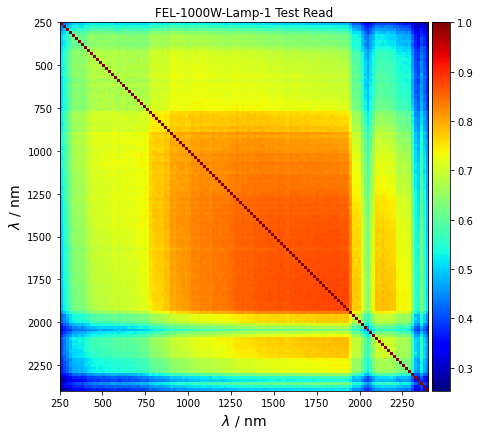

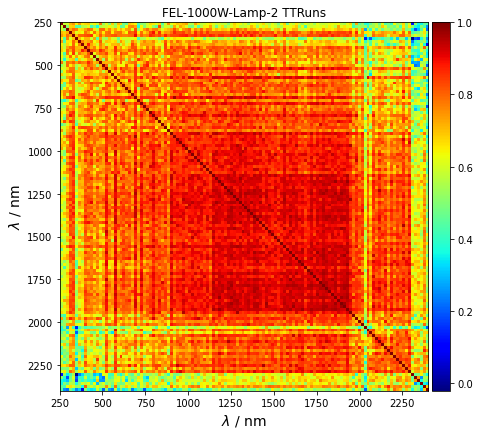

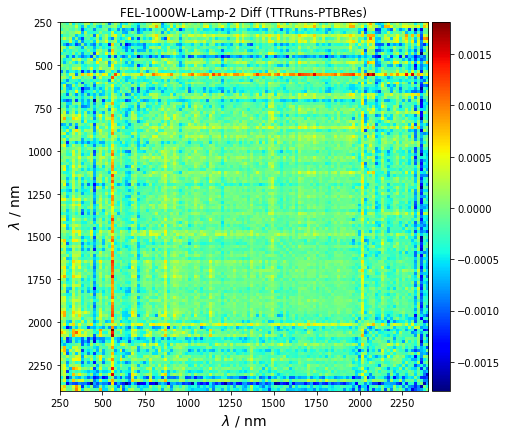

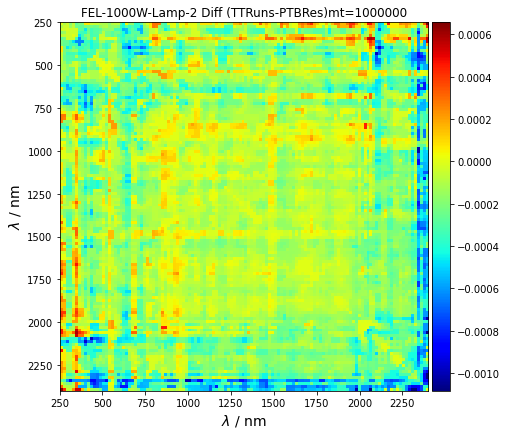

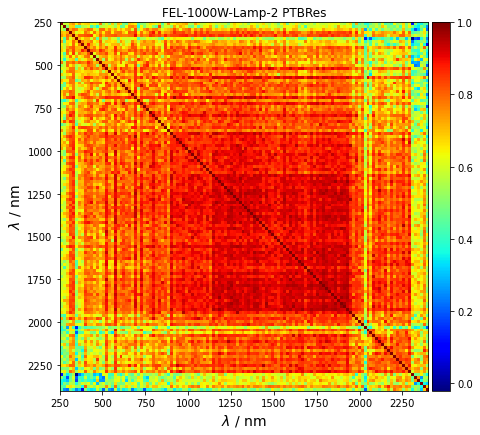

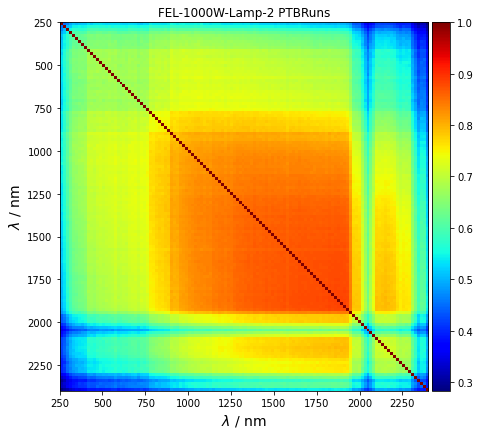

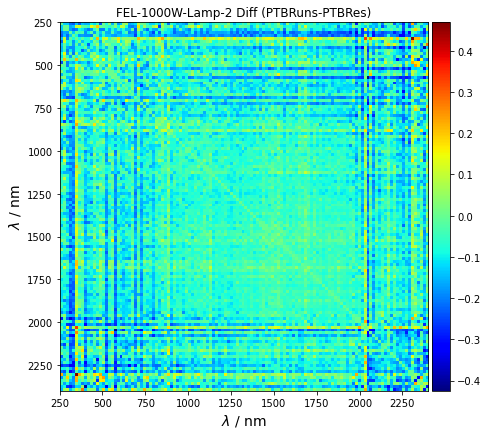

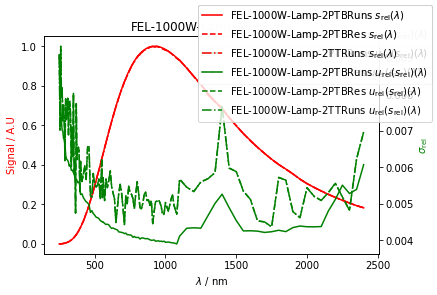

Processing: FEL-1000W-Lamp-3  from dir: E:/TTBV/Python/PTB/Lamps/FEL-1000W-Lamp-3/MC-Data-FEL-1000W-Lamp-3
Store results into: MCSim_Test/Lamps/FEL-1000W-Lamp-3
Number of Runs: 12051
Shape of the covariance matrix: (124, 124)
Shape of the corr matrix (generated from the cov matrix): (124, 124)


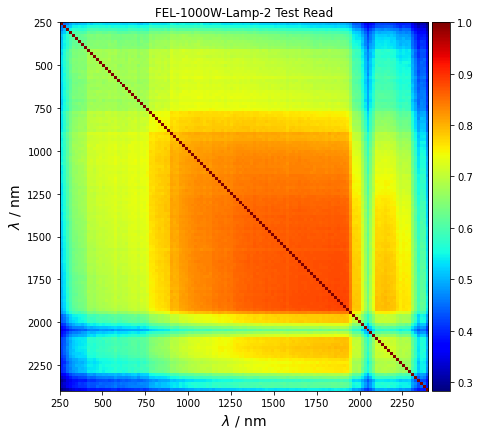

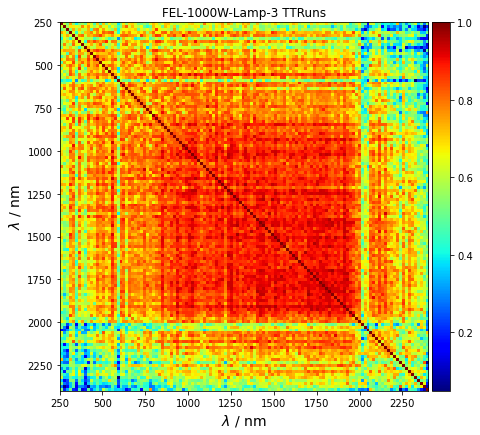

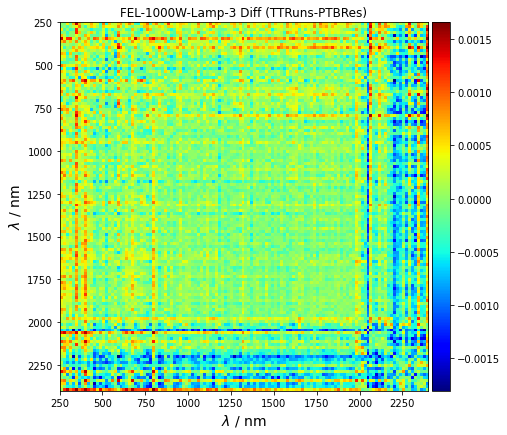

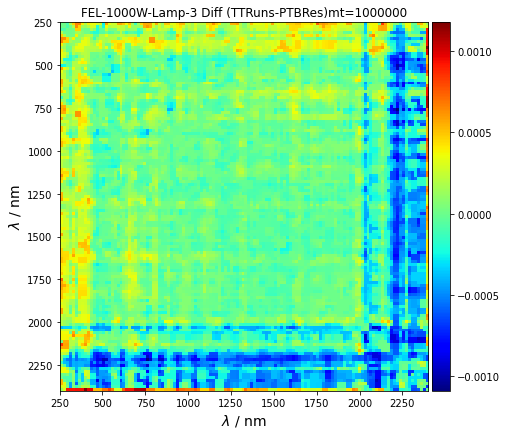

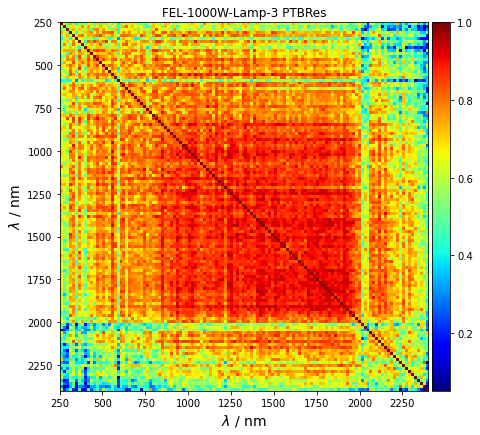

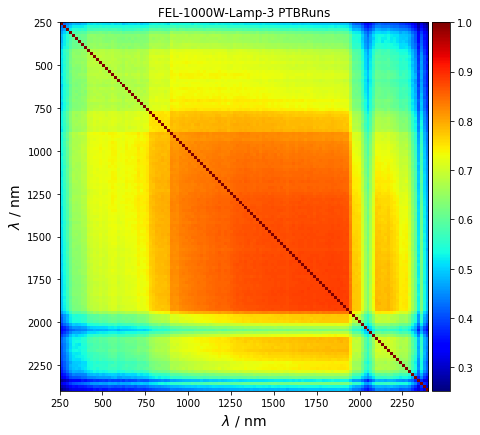

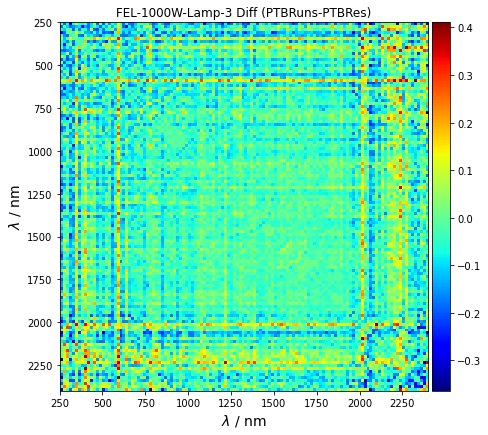

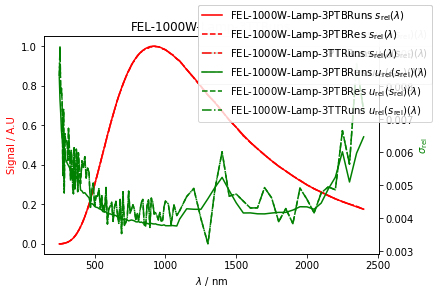

Processing: FEL-1000W-Lamp-4  from dir: E:/TTBV/Python/PTB/Lamps/FEL-1000W-Lamp-4/MC-Data-FEL-1000W-Lamp-4
Store results into: MCSim_Test/Lamps/FEL-1000W-Lamp-4
Number of Runs: 12052
Shape of the covariance matrix: (124, 124)
Shape of the corr matrix (generated from the cov matrix): (124, 124)


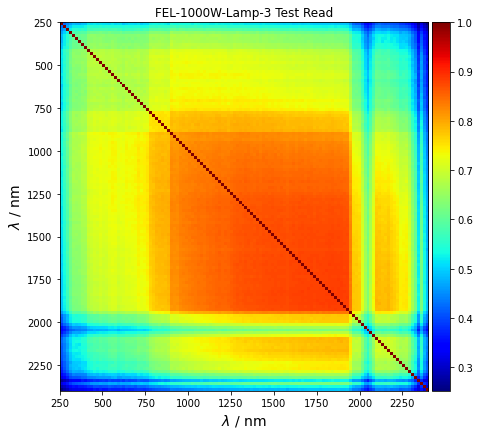

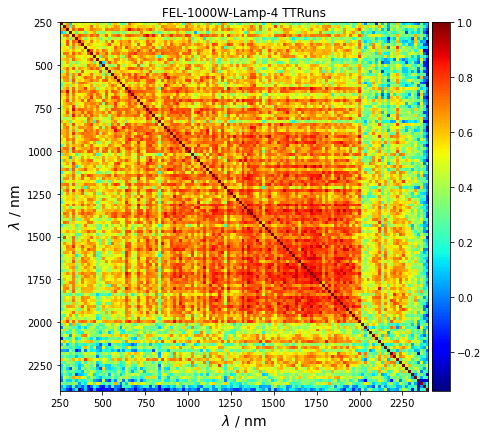

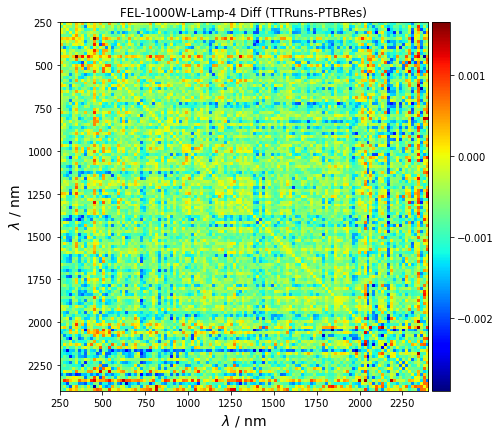

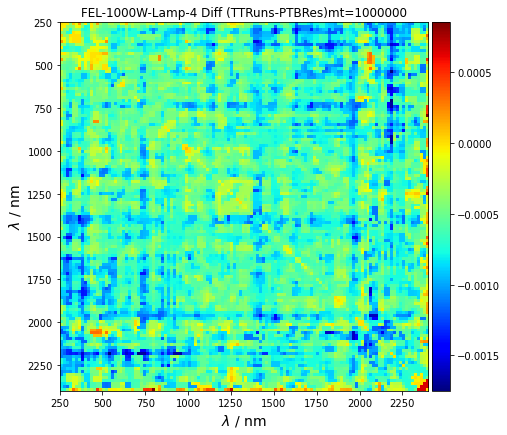

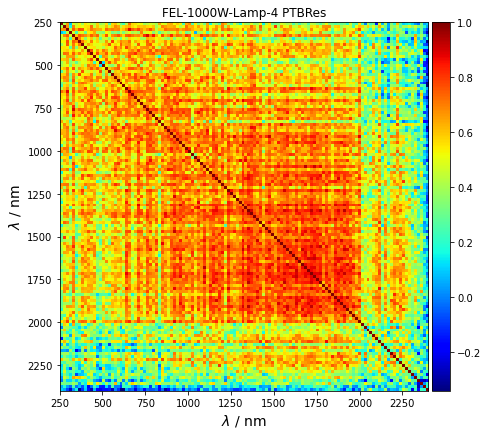

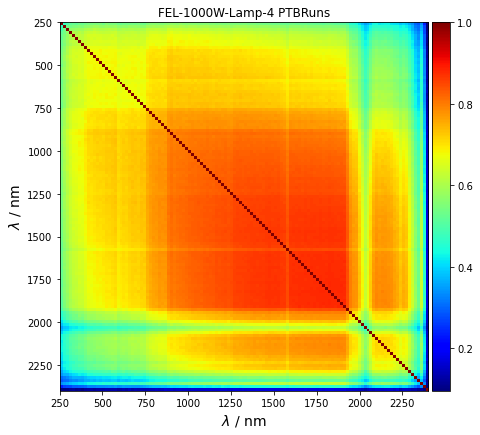

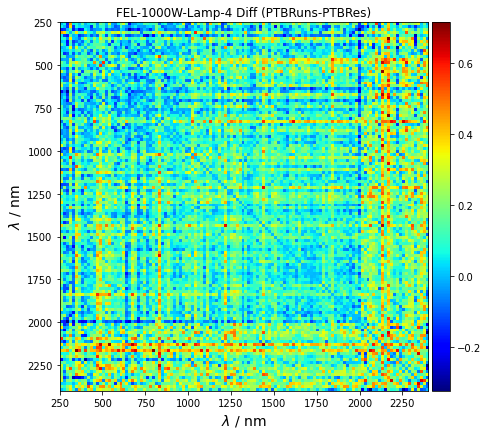

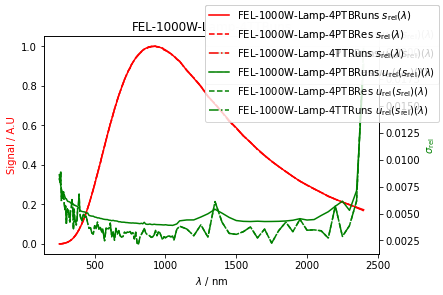

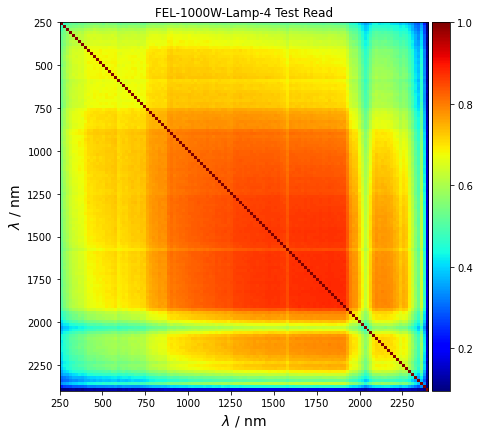

In [16]:
import fnmatch
import scipy

def conv(x):
    return x.replace(',', '.').encode()

# Prepare using all lists with names
Radiometerlist = ['Rad1', 'Rad2', 'Rad3', 'Rad4', 'Rad5']
Photometerlist = ['Phot1', 'Phot2', 'Phot3', 'Phot4', 'Phot5']
Lamplist = ['FEL-1000W-Lamp-1','FEL-1000W-Lamp-2','FEL-1000W-Lamp-3','FEL-1000W-Lamp-4']

# Take one of the above lists to work with after the in statement
for rad in Lamplist:
    directory, out_dir_res = get_data_dir(rad)

    # generate the result dir for the data
    os.makedirs(out_dir_res, exist_ok=True)

    print( 'Processing:', rad, ' from dir:', directory)
    print( 'Store results into:', out_dir_res)
    count = len(fnmatch.filter(os.listdir(directory), '*.txt')) + len(fnmatch.filter(os.listdir(directory), '*.dat'))
    print( 'Number of Runs:', count)
    spectrum = None
    bFirst = True

    # read all runs into the MMCVectorVar-class instance spectrum
    for i, filename in enumerate(os.scandir(directory)):
        if filename.is_file():
            data = np.loadtxt(filename).T
            if bFirst:
                spectrum = MCVectorVar( elements=data.shape[1])
                spectrum.allocate(trials=count)
                bFirst = False
            spectrum.val[i] = data[1]

    # evaluate the samples and generate the integral data (mean, std, cov, corr)
    spectrum.calc_cov_matrix_from_data()

    # read the integral information (mean, std, cov matrix) given in the dataset too
    cov_matrix_ptb = np.genfromtxt((conv(x) for x in open(directory + '/../' + rad + '-CovarianceMatrix.tsv')), delimiter='\t')
    print( 'Shape of the covariance matrix:', cov_matrix_ptb.shape)
    v_std_ptb, corr_matrix_ptb = MCVectorVar.calc_corr_matrix_static(cov_matrix_ptb)
    print( 'Shape of the corr matrix (generated from the cov matrix):', corr_matrix_ptb.shape)

    # The mean values are only available for Photometers and Radiometers only
    file_mean_data = directory + '/../' + rad + ' Calibdata.txt'
    trials = 1000000
    if os.path.isfile(file_mean_data):
        # adjust the reading if required
        if 'Phot' in rad:
            skip = 7
        else:
            skip = 5
        data_mean = np.genfromtxt((conv(x) for x in open(file_mean_data)), delimiter='\t', skip_header=skip).T
        spectrumPTB = MCVectorVar( elements=data_mean.shape[1])
        spectrumPTB.set_vector_param(v_mean = data_mean[1], v_std=data_mean[2]/2, cov=cov_matrix_ptb)
    else:
        # the file with the mean value is not available --> take the mean from the runs
        data_mean = spectrum.val[0]
        spectrumPTB = MCVectorVar( elements=data_mean.shape[0])
        spectrumPTB.set_vector_param(v_mean = spectrum.val[0], v_std=spectrum.v_std, cov=cov_matrix_ptb)
    # start with the integral data from PTB dataset and generate multivariate normal distributions (new runs)
    spectrumTT = pickle_copy(spectrumPTB)
    spectrumTT.generate_numbers(trials=trials)

    plotCorrelation(spectrumTT.corr_matrix, data[0], rad + ' TTRuns')
    save_fig( out_dir_res,  filename='Corr_TTRuns' + rad)
    # only for chek (here are some problems with the wl of normalization, therefore compare the median filtered ones only
    plotCorrelation(spectrumTT.corr_matrix - corr_matrix_ptb, data[0], rad + ' Diff (TTRuns-PTBRes)')
    #save_fig( out_dir_res,  filename='Corr_DiffTT' + rad)
    # filter due to the problem at the normalization point
    medFilter = scipy.ndimage.median_filter(spectrumTT.corr_matrix - corr_matrix_ptb, size=3)
    plotCorrelation( medFilter, data[0], rad + ' Diff (TTRuns-PTBRes)m' + 't='+ str(trials))
    save_fig( out_dir_res,  filename='Corr_DiffTTm' + rad)

    plotCorrelation(corr_matrix_ptb, data[0], rad + ' PTBRes')
    save_fig( out_dir_res,  filename='Corr_PTBRes' + rad)

    plotCorrelation(spectrum.corr_matrix, data[0], rad + ' PTBRuns')
    save_fig( out_dir_res,  filename='Corr_PTBRuns' + rad)

    plotCorrelation(spectrum.corr_matrix - corr_matrix_ptb, data[0], rad + ' Diff (PTBRuns-PTBRes)')
    save_fig( out_dir_res,  filename='Corr_Diff' + rad)

    # plot the mean and stddev data for comparison
    fig, ax1, ax2 = plotMCResult(data[0], spectrum, rad + 'PTBRuns')
    if spectrumPTB:
        plotMCResult(data[0], spectrumPTB, rad + 'PTBRes', fig=fig, ax1=ax1, ax2=ax2, diagnumber=1)
    if spectrumTT:
        plotMCResult(data[0], spectrumTT, rad + 'TTRuns', fig=fig, ax1=ax1, ax2=ax2, diagnumber=2)
    save_fig( out_dir_res,  filename='Mean_Runs' + rad)

    # writing all data to xls and csv for easy usage
    save_to_excel(data[0], spectrum, filename=out_dir_res + '/' + 'PTBRuns' + rad)
    save_to_csv(data[0], spectrum, filename= out_dir_res + '/' + 'PTBRuns' + rad, sep=';')
    save_to_csv(data[0], spectrum, filename= out_dir_res + '/' + 'PTBRuns' + rad + '_de', sep=';', decimal=',')
    # check the reading of the saved data
    wl2, mcVectorVar2 = load_from_csv(filename= out_dir_res + '/' + 'PTBRuns' + rad + '_de', delimiter=';')
    plotCorrelation(mcVectorVar2.corr_matrix, data[0], rad + ' Test Read')
    if spectrumPTB:
        save_to_excel(data[0], spectrumPTB, filename=out_dir_res + '/' + 'PTBRes' + rad)
        save_to_csv(data[0], spectrumPTB, filename=out_dir_res + '/' + 'PTBRes' + rad, sep=';')
        save_to_csv(data[0], spectrumPTB, filename=out_dir_res + '/' + 'PTBRes' + rad + '_de', sep=';', decimal=',')

# Make some very first MCS

In [11]:
rad = 'Phot1'
NumberTrials = 10000

# get the source and dst information
directory, out_dir_res = get_data_dir(rad)
# create a photometer (attention load_from_excel will not work at the moment due to problems with the cov matrix inversion)
wl, mcVectorVarPhot = load_from_csv(out_dir_res + '/' + 'PTBRes' + rad)
#mcVectorVarPhot.generate_numbers(trials=NumberTrials)

mcVectorVarPhotF = MCVectorVar(elements=wl.shape[0], noise_list={ 'f_mul': DistributionParam(mean=0, stddev=0.01, add_params=4)})
ideal_detector = _CMF['1931_2']['bar'][[0,2]].copy()
ideal_detector = lx.cie_interp(ideal_detector, wl_new=wl, kind='S')
mcVectorVarPhotF.set_vector_param(v_mean=ideal_detector[1])

0
Name: var NameUnit(name='L', unit='A.U.') Values: [10911.447099279627, 16.850600894507632] 0.0015443048700314102 Interval: [10878.477074089118, 10944.706306412192]
Name: var NameUnit(name='LF', unit='A.U.') Values: [10783.531759848385, 1.8189894035458565e-12] 1.6868215757649246e-16 Interval: [10783.531759848387, 10783.531759848387]
1
Name: var NameUnit(name='L', unit='A.U.') Values: [10911.449510177958, 1.8189894035458565e-12] 1.6670465292893888e-16 Interval: [10911.44951017796, 10911.44951017796]
Name: var NameUnit(name='LF', unit='A.U.') Values: [10784.610113024382, 119.92752590166876] 0.011120246781738953 Interval: [10556.964206575576, 11015.418413058123]
2
Name: var NameUnit(name='L', unit='A.U.') Values: [10911.447099279627, 16.850600894507632] 0.0015443048700314102 Interval: [10878.477074089118, 10944.706306412192]
Name: var NameUnit(name='LF', unit='A.U.') Values: [10784.610113024382, 119.92752590166876] 0.011120246781738953 Interval: [10556.964206575576, 11015.418413058123]
V

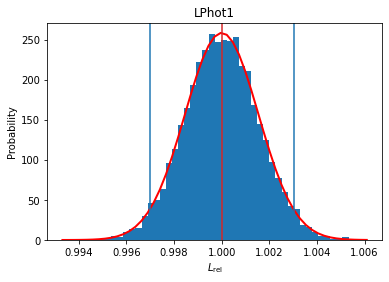

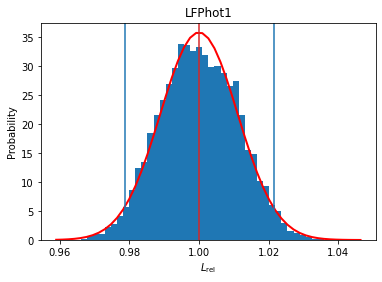

In [13]:
mcL = MCVar(name=NameUnit('L', 'A.U.'))
mcLF = MCVar(name=NameUnit('LF', 'A.U.'))

spectrumA = _CIE_ILLUMINANTS['A'].copy()
spectrumAInt = lx.cie_interp(spectrumA, wl_new=wl, kind='S')

dl = lx.getwld(wl) # wavelength differences (unequal wavelength spacings are taken into account)
dl = dl*np.ones_like(wl) # ensure array like for matrix multiplication

def model_L0( photometer, photometerF):

    L = spectrumAInt[1] @ (photometer * dl)
    LF = spectrumAInt[1] @ (photometerF * dl)
    return [L, LF]

input = [mcVectorVarPhot, mcVectorVarPhotF]
output = [mcL, mcLF]

sim = MCSimulation(trials=NumberTrials)
sim.set_input_var(input)
sim.set_output_var(output)
sim.generate()

#sim.calculate_model(model)
sim.calculate_model(model_L0)

for i in range(len(input)+1):
    print( i)
    for var in sim.output_var[i]:
        var.print_stat()

var = sim.output_var[0]
plotHistScales( var[0].val/np.mean(var[0].val), add_distribution=True, title='L' + rad, xLabel='$L_{\mathrm{rel}}$')
var = sim.output_var[1]
plotHistScales( var[1].val/np.mean(var[1].val), add_distribution=True, title='LF' + rad, xLabel='$L_{\mathrm{rel}}$')